### This notebook evaluates precipitation efficiency for MCSs in the idealized RCE simulations.

In [1]:
import numpy as np
import scipy as sp
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import warnings, random
from matplotlib import cm
import scipy.optimize
from random import randint

from scipy.optimize import curve_fit

plt.rcParams.update({'font.size': 12})

warnings.filterwarnings(action='ignore')

from plotting_utilities import *
from thermodynamic_functions import *

# colorblind friendly colormap

CB_color_cycle = [ '#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3',
                   '#999999', '#e41a1c', '#dede00']

## Loading RCE data

In [2]:
path = '/xdisk/sylvia/RCE-CAPE-exploration/'
ssts = np.arange( 285, 315, 5 )

mean_285 = xr.open_dataset( path + 'RCE_COL_MEAN_285.nc' )
mean_290 = xr.open_dataset( path + 'RCE_COL_MEAN_290.nc' )
mean_295 = xr.open_dataset( path + 'RCE_COL_MEAN_295.nc' )
mean_300 = xr.open_dataset( path + 'RCE_COL_MEAN_300.nc' )
mean_305 = xr.open_dataset( path + 'RCE_COL_MEAN_305.nc' )
mean_310 = xr.open_dataset( path + 'RCE_COL_MEAN_310.nc' )

p99_285 = xr.open_dataset( path + 'RCE_COL_99_285.nc' )
p99_290 = xr.open_dataset( path + 'RCE_COL_99_290.nc' )
p99_295 = xr.open_dataset( path + 'RCE_COL_99_295.nc' )
p99_300 = xr.open_dataset( path + 'RCE_COL_99_300.nc' )
p99_305 = xr.open_dataset( path + 'RCE_COL_99_305.nc' )
p99_310 = xr.open_dataset( path + 'RCE_COL_99_310.nc' )

clusters_285 = xr.open_dataset( path + 'RCE_COL_cluster-sizes_285.nc' )
clusters_290 = xr.open_dataset( path + 'RCE_COL_cluster-sizes_290.nc' )
clusters_295 = xr.open_dataset( path + 'RCE_COL_cluster-sizes_295.nc' )
clusters_300 = xr.open_dataset( path + 'RCE_COL_cluster-sizes_300.nc' )
clusters_305 = xr.open_dataset( path + 'RCE_COL_cluster-sizes_305.nc' )
clusters_310 = xr.open_dataset( path + 'RCE_COL_cluster-sizes_310.nc' )

In [14]:
mean_RCE = [ mean_285, mean_290, mean_295, mean_300, mean_305, mean_310 ]
p99_RCE = [ p99_285, p99_290, p99_295, p99_300, p99_305, p99_310 ]
clusters = [ clusters_295, clusters_300, clusters_305, clusters_310 ]
rad = []
for c in clusters:
    for cc in c['cluster_sizes']:
        rad.append( 2*(cc*9/np.pi)**(0.5) )
rad = np.array( rad )

##  Precipitation efficiency

In [15]:
peff_list = [ [] for i in np.arange( len(mean_RCE) ) ]
eps = 0.01802/0.02897 # ratio of MW_water to MW_air
g = 9.8 # gravity [m s-2]
rho_w = 997 # density of water [kg m-3]
R_air = 287.058 # [J kg-1 K-1]

In [16]:
# Calculate the gradient with respect to pressure of the saturation vapor mixing ratio
for iterator, array in enumerate( p99_RCE ):
    precip_RCE = array['p_rate']
    T_RCE = array['TABS']
    p_RCE = array['p'] * 100. # converting hPa -> Pa
    qvsat_RCE = eps * satVapP_liq(T_RCE) / ( p_RCE - satVapP_liq(T_RCE) )
    RH = array['QV'] / (qvsat_RCE * 1000.) # factor of 1000. to put both in [g kg-1]

    # Then calculate the gradient versus altitude in that saturation vapor mixing ratio
    dqvsat_dz_RCE = qvsat_RCE.differentiate( 'z' )
    
    # Convert pressure velocity to vertical velocity
    rho_air = p_RCE / (R_air * T_RCE) # [kg m-3]
    w_RCE = -1. * array['ascent'] / rho_air / g # [m s-1]

    # Multiply the gradient with respect to altitude by vertical velocity
    integrand = w_RCE * dqvsat_dz_RCE * rho_air
    
    # Determine the lifting condensation level, Lawrence BAMS 2005 approximation for Tdes
    Tmean = T_RCE.mean( dim={'clusters'} )
    Tdew = T_RCE - ( (100 - 100*RH[0])/5 )
    Tdew = xr.broadcast( Tdew, Tmean )[0].mean( dim={'clusters'} )
    k = np.abs( Tmean - Tdew ).argmin( 'z' ).values
    
    # Determine the cold-point tropopause,
    # i.e. where the temperature change becomes negative as the stratosphere warms
    j = np.argwhere( (Tmean[:-1].values - Tmean[1:].values) < 0 )[0,0]
    
    # Integrate the condensation rate over the altitudes
    cond_rate_RCE = integrand[:,k+1:j-1].integrate( coord='z' )
    peff_RCE = precip_RCE / 3600 / cond_rate_RCE  # index 0 for p_RCE is the surface
    peff_list[iterator] = peff_RCE
    print( np.nanmin(peff_RCE), np.nanmean(peff_RCE), np.nanmax(peff_RCE) )

0.0 0.3008260127956419 0.5560265739231939
0.0 0.2428110438157165 0.5857953180542207
0.0 0.2748531667304753 0.928539895688491
0.0 0.19202207064503524 0.54044781571604
0.0 0.10435301733110951 0.307938644998071
0.0 0.04229518875624965 0.11108742034429869


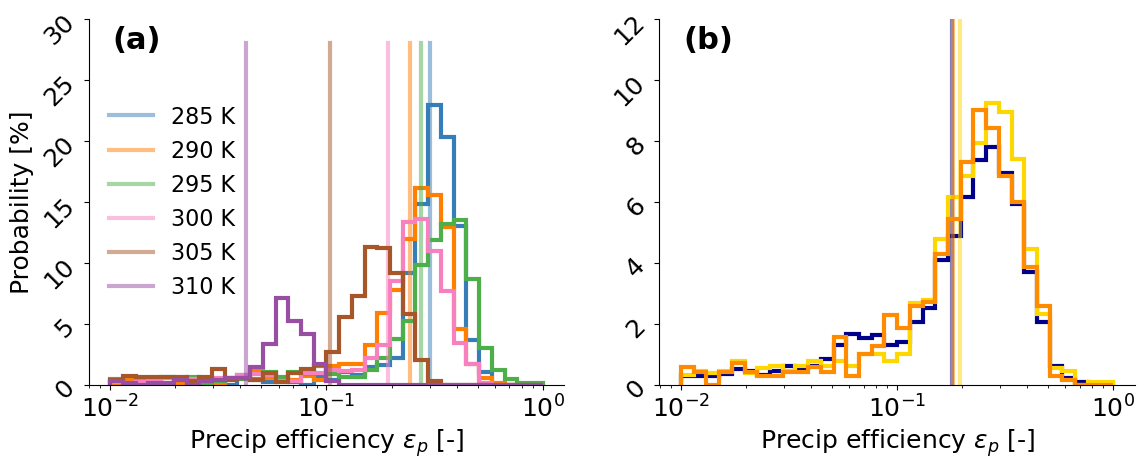

In [52]:
fs = 18
fig, ax = plt.subplots( 1, 2, figsize =(13.5, 4.75) )

for i, l in zip( peff_list, np.arange(len(peff_list)) ):
    wgts = np.ones_like( i )/float( len( i ) )*100.
    ax[0].hist( i, bins=np.logspace(-2, 0, 35), histtype='step', weights=wgts, linewidth=3,
               edgecolor=CB_color_cycle[l] )
    ax[0].plot( [np.nanmean(i), np.nanmean(i)], [0, 28], linewidth=3, ls='-', alpha=0.5,
               color=CB_color_cycle[l], label=str(ssts[l])+' K' )
ax[0].legend( frameon=False, loc='center left', fontsize=fs-2 )
ax[0].set_ylim( [0, 30] )
ax[0].set_ylabel( 'Probability [%]', fontsize=fs )

all_precipeff = np.concatenate( (peff_list[1], peff_list[2], peff_list[3], peff_list[4], peff_list[5]) )
wgts = np.ones_like( all_precipeff )/float( len( all_precipeff ) )*100.
ax[1].hist( all_precipeff, bins=np.logspace(-2, 0, 35), histtype='step', weights=wgts, linewidth=3, edgecolor='darkblue' )
ax[1].plot( [np.nanmedian(all_precipeff), np.nanmedian(all_precipeff)], [0, 15], ls='-', alpha=0.5, linewidth=3, color='darkblue' )
i = np.argwhere( rad < 110 )
precip_eff_small = all_precipeff[i[:,0]]
wgts = np.ones_like( precip_eff_small )/float( len( precip_eff_small ) )*100.
ax[1].hist( precip_eff_small, bins=np.logspace(-2, 0, 35), histtype='step', weights=wgts, linewidth=3, edgecolor='gold' )
ax[1].plot( [np.nanmedian(precip_eff_small), np.nanmedian(precip_eff_small)], [0, 15], ls='-', alpha=0.5, linewidth=3, color='gold' )
i = np.argwhere( rad >= 150 )
precip_eff_large = all_precipeff[i[:,0]]
wgts = np.ones_like( precip_eff_large )/float( len( precip_eff_large ) )*100.
ax[1].hist( precip_eff_large, bins=np.logspace(-2, 0, 35), histtype='step', weights=wgts, linewidth=3, edgecolor='darkorange' )
ax[1].plot( [np.nanmedian(precip_eff_large), np.nanmedian(precip_eff_large)], [0, 15], ls='-', alpha=0.5, linewidth=3, color='darkorange' )
ax[1].set_ylim( [0, 12] )

let = [ '(a)', '(b)' ]
for i, a in enumerate(ax):
    a.set_xlabel( r'Precip efficiency $\varepsilon_p$ [-]', fontsize=fs )
    a.set_xscale( 'log' )
    a.tick_params( 'both', labelsize=fs )
    a.tick_params( 'y', rotation=45 )
    a.set_xlim( [-2, 0] )
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.text( 0.05, 0.92, let[i], transform=a.transAxes, weight='bold', fontsize=fs+4 )

fig.savefig( '/groups/sylvia/JAS-MCS-rain/figures/precipeff-RCE.pdf', bbox_inches='tight' )
plt.show()